##ある匂い物質の化学的情報を入力として、おの物質の匂いのスコアを予測する。匂いは146種類あるので、目的変数を自動で変更し、すべての匂いについて決定係数の値を算出する。5つの説明変数について結果を比較する。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# フォルダの移動には"%cd"を使用します。
# 作業フォルダへ移動
%cd /content/drive/'My Drive'/'情報管理'/'卒論'/
# 現在のフォルダの中身を表示
%ls

Mounted at /content/drive
/content/drive/My Drive/情報管理/卒論
 aaa.ipynb                                random_forest.ipynb
 aaa.xlsx                                 rdkit_desc.csv
'ATLAS_odor_character_profiles (1).csv'   tunerCV.ipynb
 ATLAS_odor_character_profiles.csv        Untitled0.ipynb
 b.xlsx                                   Untitled1.ipynb
 lgbm_tuner_cv.ipynb                      Untitled2.ipynb
 lgbmチューニング.ipynb                   Untitled3.ipynb
 lgmb.ipynb                               Untitled5.ipynb
 light_alldata.ipynb                      xgboost.ipynb
 lightgbm_mo3.ipynb                       全データ個別ipynb
 maccskeys.csv                            全データ自動.ipynb
 mordred_desc.csv                         卒論最新.ipynb
 morganfp2.csv                            各データ特徴量.ipynb
 morganfp3.csv                            学習曲線ipynb.ipynb
 my_dataframe.xlsx


In [ ]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
# import optuna.integration.lightgbm as lgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import lightgbm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

##データ準備

In [ ]:
#説明変数
df_morganfp3 = pd.read_csv('morganfp3.csv', sep='\t')
df_morganfp2 = pd.read_csv('morganfp2.csv', sep='\t')
df_maccs = pd.read_csv('maccskeys.csv', sep='\t')
df_rd = pd.read_csv('rdkit_desc.csv', sep='\t')
df_mordred = pd.read_csv('mordred_desc.csv', sep='\t')

#目的変数
df_atlas = pd.read_csv('ATLAS_odor_character_profiles.csv', sep='\t')

## maccskeys

説明変数をmaccskeys、目的変数を146個の匂い記述子のスコアとする
評価指標を決定係数（相関係数の2乗）とし、LightGBMで回帰を行う。交差検証として5分割交差検証を実行する。


In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率               
          }

r2s_ma = {}
rmses = {}
cv_result_opt =[]

targets = list(df_atlas1.drop(["ID",	"Molecule",	"NAME",	"CAS",	"CID",	"Mixture"],axis =1).columns)

In [ ]:
for target in targets:
    data =df_atlas1.loc[:, ['Molecule', 'CAS',target]]
    data = pd.merge(data, df_maccs.dropna(axis=1), on=['CAS','Molecule'],how='right')
    X = data.drop(['Molecule','CAS',target], axis=1)
    feature_list = list(X.columns)
    # 目的変数（匂い記述子 1つ）
    y = data[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    cv =KFold(n_splits=5,random_state=0,shuffle = True)
    # X = X.values
    r2_list = []
    mae_list = []
    rmse_list = []

    for train_index,test_index in cv.split(X):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test= y[train_index],y[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
        # print(X_train)
        # モデルの作成
        lgb_results = {}    

        model = lgb.train(
                        params,                    # ハイパーパラメータをセット
                        lgb_train,              # 訓練データを訓練用にセット
                        valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                        valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                        num_boost_round=100,              # 計算回数
                        early_stopping_rounds=50,         # アーリーストッピング設定
                        evals_result=lgb_results,
                        verbose_eval=-1,                  # ログを最後の1つだけ表示
                        )  
        
        
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        

        # 評価
        correlation = np.corrcoef(y_test,y_pred)
        r2 = correlation[0,1]*correlation[0,1]
        
        
        r2_list.append(r2)
        
    

    
    r2_mean = np.mean(r2_list)
   

    r2s_ma[target] = np.mean(r2_list)
    
print('r2',r2s_ma)


In [ ]:
ma=r2s_ma
ma = pd.DataFrame.from_dict(ma,orient="index",columns=["R2"])
ma = ma.sort_values(by="R2", ascending=False)
ma

,R2
10_PEAR,0.507996
40_CEDARWOOD,0.506134
6_PINEAPPLE,0.505582
5_FRUITY_OTHER_THAN_CITRUS,0.488674
128_SWEATY,0.411449
...,...
119_BUTTERY_FRESH_BUTTER,0.029609
33_SEASONING_(FOR_MEAT),0.028666
45_CHOCOLATE,0.022946
34_BLACK_PEPPER,0.014470


In [ ]:
ma.mean()

R2    0.204617
dtype: float64

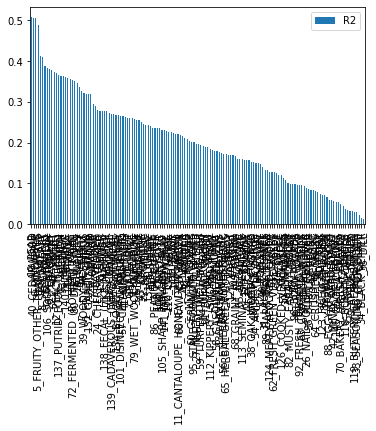

In [ ]:
ma.plot.bar()

##mog3

In [ ]:
df_atlas1=df_atlas.iloc[:, 0:152]

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                # シード値
          }

r2s_mo3 = {}
rmses = {}
cv_result_opt =[]

targets = list(df_atlas1.drop(["ID",	"Molecule",	"NAME",	"CAS",	"CID",	"Mixture"],axis =1).columns)

In [ ]:
for target in targets:
    data =df_atlas1.loc[:, ['Molecule', 'CAS',target]]
    data = pd.merge(data, df_morganfp3.dropna(axis=1), on=['CAS','Molecule'],how='right')
    X = data.drop(['Molecule','CAS',target], axis=1)
    feature_list = list(X.columns)
    # 目的変数（匂い記述子 1つ）
    y = data[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    cv =KFold(n_splits=5,random_state=0,shuffle = True)
    # X = X.values
    r2_list = []
    mae_list = []
    rmse_list = []

    for train_index,test_index in cv.split(X):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test= y[train_index],y[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
        # print(X_train)
        # モデルの作成
        lgb_results = {}    

        model = lgb.train(
                        params,                    # ハイパーパラメータをセット
                        lgb_train,              # 訓練データを訓練用にセット
                        valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                        valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                        num_boost_round=100,              # 計算回数
                        early_stopping_rounds=50,         # アーリーストッピング設定
                        evals_result=lgb_results,
                        verbose_eval=-1,                  # ログを最後の1つだけ表示
                        )  
        
        
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        # print('rmse:',mean_squared_error(y_test, y_pred, squared=False))
        # print('決定係数:',r2_score(y_test, y_pred))
        
        true = y_test
        pred = y_pred.reshape(-1)
        df = pd.DataFrame({
        'Measured': true,
        'Predicted': pred })

        # plt.style.use(['science','no-latex'])
        # plt.figure(figsize=(15,15))
        # plt.rcParams.update({'font.size': 10})
        # gfg = sns.jointplot(x="Predicted", 
        #               y="Measured", 
        #               data=df,
        #               # kind="reg",
        #               color="k",
        #               marginal_kws=dict(bins=50,color='b'));

        # 評価
        correlation = np.corrcoef(y_test,y_pred)
        r2 = correlation[0,1]*correlation[0,1]
        
        
        r2_list.append(r2)
        
    

    
    r2_mean = np.mean(r2_list)
   

    r2s_mo3[target] = np.mean(r2_list)
    
print('r2',r2s_mo3)
print('rmse',rmses)

In [ ]:
mo3=r2s_mo3
mo3 = pd.DataFrame.from_dict(mo3,orient="index",columns=["R2"])
mo3 = mo3.sort_values(by="R2", ascending=False)
mo3

,R2
5_FRUITY_OTHER_THAN_CITRUS,0.477262
6_PINEAPPLE,0.455764
10_PEAR,0.436876
8_STRAWBERRY,0.400996
12_PEACH_(FRUIT),0.374231
...,...
88_EGGY_(FRESH_EGGS),0.023365
45_CHOCOLATE,0.023031
122_POPCORN,0.020431
50_MALTY,0.019378


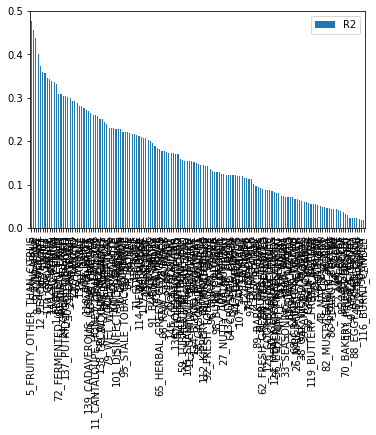

In [ ]:
mo3.plot.bar()

In [ ]:
mo3.mean()

R2    0.165328
dtype: float64

##mo2

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                # シード値
          }

r2s_mo2 = {}
rmses = {}
cv_result_opt =[]

targets = list(df_atlas1.drop(["ID",	"Molecule",	"NAME",	"CAS",	"CID",	"Mixture"],axis =1).columns)

In [ ]:
for target in targets:
    data =df_atlas1.loc[:, ['Molecule', 'CAS',target]]
    data = pd.merge(data, df_morganfp2.dropna(axis=1), on=['CAS','Molecule'],how='right')
    X = data.drop(['Molecule','CAS',target], axis=1)
    feature_list = list(X.columns)
    # 目的変数（匂い記述子 1つ）
    y = data[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    cv =KFold(n_splits=5,random_state=0,shuffle = True)
    # X = X.values
    r2_list = []
    mae_list = []
    rmse_list = []

    for train_index,test_index in cv.split(X):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test= y[train_index],y[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
        # print(X_train)
        # モデルの作成
        lgb_results = {}    

        model = lgb.train(
                        params,                    # ハイパーパラメータをセット
                        lgb_train,              # 訓練データを訓練用にセット
                        valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                        valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                        num_boost_round=100,              # 計算回数
                        early_stopping_rounds=50,         # アーリーストッピング設定
                        evals_result=lgb_results,
                        verbose_eval=-1,                  # ログを最後の1つだけ表示
                        )  
        
        
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        

        # 評価
        correlation = np.corrcoef(y_test,y_pred)
        r2 = correlation[0,1]*correlation[0,1]
        
        
        r2_list.append(r2)
        
    

    
    r2_mean = np.mean(r2_list)
   

    r2s_mo2[target] = np.mean(r2_list)
    
print('r2',r2s_mo2)


In [ ]:
mo2=r2s_mo2
mo2 = pd.DataFrame.from_dict(mo2,orient="index",columns=["R2"])
mo2 = mo2.sort_values(by="R2", ascending=False)
mo2

,R2
5_FRUITY_OTHER_THAN_CITRUS,0.477961
6_PINEAPPLE,0.455285
10_PEAR,0.449723
8_STRAWBERRY,0.412031
128_SWEATY,0.362083
...,...
45_CHOCOLATE,0.023031
122_POPCORN,0.022535
125_SOUPY,0.019395
9_APPLE_(FRUIT),0.019395


In [ ]:
mo2.mean()

R2    0.165239
dtype: float64

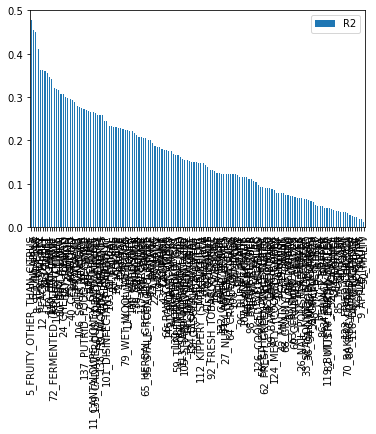

In [ ]:
mo2.plot.bar()

##rdkit

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                # シード値
          }

r2s_rd = {}
rmses = {}
cv_result_opt =[]

targets = list(df_atlas1.drop(["ID",	"Molecule",	"NAME",	"CAS",	"CID",	"Mixture"],axis =1).columns)

In [ ]:
for target in targets:
    data =df_atlas1.loc[:, ['Molecule', 'CAS',target]]
    data = pd.merge(data, df_rd.dropna(axis=1), on=['CAS','Molecule'],how='right')
    X = data.drop(['Molecule','CAS',target], axis=1)
    feature_list = list(X.columns)
    # 目的変数（匂い記述子 1つ）
    y = data[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    cv =KFold(n_splits=5,random_state=0,shuffle = True)
    # X = X.values
    r2_list = []
    mae_list = []
    rmse_list = []

    for train_index,test_index in cv.split(X):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test= y[train_index],y[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
        # print(X_train)
        # モデルの作成
        lgb_results = {}    

        model = lgb.train(
                        params,                    # ハイパーパラメータをセット
                        lgb_train,              # 訓練データを訓練用にセット
                        valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                        valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                        num_boost_round=100,              # 計算回数
                        early_stopping_rounds=50,         # アーリーストッピング設定
                        evals_result=lgb_results,
                        verbose_eval=-1,                  # ログを最後の1つだけ表示
                        )  
        
        
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        # print('rmse:',mean_squared_error(y_test, y_pred, squared=False))
        # print('決定係数:',r2_score(y_test, y_pred))
        
        true = y_test
        pred = y_pred.reshape(-1)
        df = pd.DataFrame({
        'Measured': true,
        'Predicted': pred })

        # plt.style.use(['science','no-latex'])
        # plt.figure(figsize=(15,15))
        # plt.rcParams.update({'font.size': 10})
        # gfg = sns.jointplot(x="Predicted", 
        #               y="Measured", 
        #               data=df,
        #               # kind="reg",
        #               color="k",
        #               marginal_kws=dict(bins=50,color='b'));

        # 評価
        correlation = np.corrcoef(y_test,y_pred)
        r2 = correlation[0,1]*correlation[0,1]
        
        
        r2_list.append(r2)
        
    

    
    r2_mean = np.mean(r2_list)
   

    r2s_rd[target] = np.mean(r2_list)
print('r2',r2s_rd)
print('rmse',rmses)

In [ ]:
rd=r2s_rd
rd = pd.DataFrame.from_dict(rd,orient="index",columns=["R2"])
rd = rd.sort_values(by="R2", ascending=False)
rd

,R2
40_CEDARWOOD,0.580151
132_GARLIC_ONION,0.508712
140_SICKENING,0.475699
131_SULFIDIC,0.469282
143_LIGHT,0.449086
...,...
88_EGGY_(FRESH_EGGS),0.041538
73_BEERY,0.041519
78_WET_PAPER,0.033202
76_CARDBOARD,0.030587


In [ ]:
rd.mean()

R2    0.222184
dtype: float64

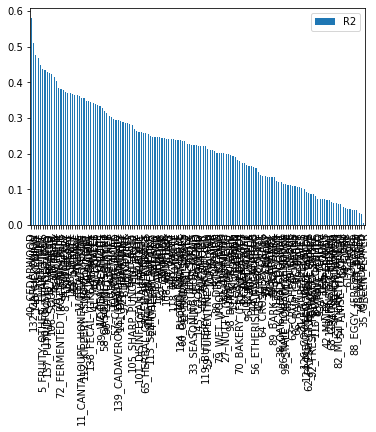

In [ ]:
rd.plot.bar()

##mordred_desc

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率                # シード値
          }

r2s_mord = {}
rmses = {}
cv_result_opt =[]

targets = list(df_atlas1.drop(["ID",	"Molecule",	"NAME",	"CAS",	"CID",	"Mixture"],axis =1).columns)

In [ ]:
for target in targets:
    data =df_atlas1.loc[:, ['Molecule', 'CAS',target]]
    data = pd.merge(data, df_mordred.dropna(axis=1), on=['CAS','Molecule'],how='right')
    X = data.drop(['Molecule','CAS',target], axis=1)
    feature_list = list(X.columns)
    # 目的変数（匂い記述子 1つ）
    y = data[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    cv =KFold(n_splits=5,random_state=0,shuffle = True)
    # X = X.values
    r2_list = []
    mae_list = []
    rmse_list = []

    for train_index,test_index in cv.split(X):
        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test= y[train_index],y[test_index]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
        # print(X_train)
        # モデルの作成
        lgb_results = {}    

        model = lgb.train(
                        params,                    # ハイパーパラメータをセット
                        lgb_train,              # 訓練データを訓練用にセット
                        valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                        valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                        num_boost_round=100,              # 計算回数
                        early_stopping_rounds=50,         # アーリーストッピング設定
                        evals_result=lgb_results,
                        verbose_eval=-1,                  # ログを最後の1つだけ表示
                        )  
        
        
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        
        # print('rmse:',mean_squared_error(y_test, y_pred, squared=False))
        # print('決定係数:',r2_score(y_test, y_pred))
        
        true = y_test
        pred = y_pred.reshape(-1)
        df = pd.DataFrame({
        'Measured': true,
        'Predicted': pred })

        # plt.style.use(['science','no-latex'])
        # plt.figure(figsize=(15,15))
        # plt.rcParams.update({'font.size': 10})
        # gfg = sns.jointplot(x="Predicted", 
        #               y="Measured", 
        #               data=df,
        #               # kind="reg",
        #               color="k",
        #               marginal_kws=dict(bins=50,color='b'));

        # 評価
        correlation = np.corrcoef(y_test,y_pred)
        r2 = correlation[0,1]*correlation[0,1]
        
        
        r2_list.append(r2)
        
    

    
    r2_mean = np.mean(r2_list)
   

    r2s_mord[target] = np.mean(r2_list)
print('r2',r2s_mord)
print('rmse',rmses)

In [ ]:
mord=r2s_mord
mord = pd.DataFrame.from_dict(mord,orient="index",columns=["R2"])
mord = mord.sort_values(by="R2", ascending=False)
mord

,R2
40_CEDARWOOD,0.550477
132_GARLIC_ONION,0.543600
131_SULFIDIC,0.470796
130_HOUSEHOLD_GAS,0.451042
140_SICKENING,0.430902
...,...
77_ROPE,0.037455
92_FRESH_TOBACCO_SMOKE,0.036738
42_MINTY_PEPPERMINT,0.029894
35_GREEN_PEPPER,0.022869


In [ ]:
mord.mean()

R2    0.2305
dtype: float64

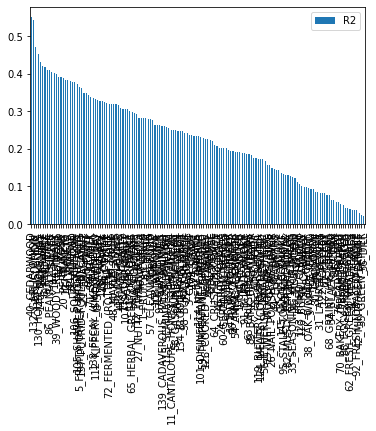

In [ ]:
mord.plot.bar()

##結果の比較と考察
5種類の説明変数の場合の結果を比較する。
RDKit記述子 とmordred記述子の結果は類似しており、maccskeys, morganfp3, morganfp2の３つの結果も類似している。データに含まれる情報によって、それぞれで予測しやすい匂い記述子が存在する可能性が考えられ、これらの匂い記述子には共通の特徴などが存在するのかを確かめる。 決定係数が上位 10 個の匂い記述子で、 ATLAS の匂い記述子データのそれぞれのスコアにおける相関係数を算出した。
RDKit記述子 とmordred記述子の結果は類似しているため、RDKit記述子の場合のみで実行し、maccskeys, morganfp3, morganfp2の３つの結果も類似しているので、maccskeysのみで実行した。
しかし、上位の匂い記述子の間でも相関が小さいものもあり、説明変数によって特定の系統の匂いが予想しやすいとは考えられない。

In [ ]:
ma.head(15)

,R2
10_PEAR,0.507996
40_CEDARWOOD,0.506134
6_PINEAPPLE,0.505582
5_FRUITY_OTHER_THAN_CITRUS,0.488674
128_SWEATY,0.411449
8_STRAWBERRY,0.409659
127_RANCID,0.388261
106_SOUR_VINEGAR,0.382645
20_PERFUMERY,0.380228
21_FRAGRANT,0.378043


In [ ]:
mo3.head(15)

,R2
5_FRUITY_OTHER_THAN_CITRUS,0.477262
6_PINEAPPLE,0.455764
10_PEAR,0.436876
8_STRAWBERRY,0.400996
12_PEACH_(FRUIT),0.374231
143_LIGHT,0.360618
47_SWEET,0.357427
110_CAT_URINE,0.345992
128_SWEATY,0.343269
140_SICKENING,0.339758


In [ ]:
mo2.head(15)

,R2
5_FRUITY_OTHER_THAN_CITRUS,0.477961
6_PINEAPPLE,0.455285
10_PEAR,0.449723
8_STRAWBERRY,0.412031
128_SWEATY,0.362083
12_PEACH_(FRUIT),0.361516
143_LIGHT,0.360043
47_SWEET,0.355266
140_SICKENING,0.346203
110_CAT_URINE,0.341931


In [ ]:
rd.head(15)

,R2
40_CEDARWOOD,0.580151
132_GARLIC_ONION,0.508712
140_SICKENING,0.475699
131_SULFIDIC,0.469282
143_LIGHT,0.449086
5_FRUITY_OTHER_THAN_CITRUS,0.436413
130_HOUSEHOLD_GAS,0.435206
137_PUTRID_FOUL_DECAYED,0.427527
127_RANCID,0.425621
106_SOUR_VINEGAR,0.423269


In [ ]:
mord.head(15)


,R2
40_CEDARWOOD,0.550477
132_GARLIC_ONION,0.543600
131_SULFIDIC,0.470796
130_HOUSEHOLD_GAS,0.451042
140_SICKENING,0.430902
143_LIGHT,0.419079
6_PINEAPPLE,0.416260
93_INCENSE,0.410036
86_PEANUT_BUTTER,0.409971
47_SWEET,0.405130


In [ ]:
df_mac.tail(10)

,R2
73_BEERY,0.043999
116_BURNT_CANDLE,0.036238
35_GREEN_PEPPER,0.034273
125_SOUPY,0.031148
9_APPLE_(FRUIT),0.031148
119_BUTTERY_FRESH_BUTTER,0.029609
33_SEASONING_(FOR_MEAT),0.028666
45_CHOCOLATE,0.022946
34_BLACK_PEPPER,0.014470
36_DILL,0.012610


In [ ]:
mo3.tail(10)

,R2
85_MUSHROOM,0.037477
70_BAKERY_(FRESH_BREAD),0.031877
123_FRIED_CHICKEN,0.030596
125_SOUPY,0.023866
9_APPLE_(FRUIT),0.023866
88_EGGY_(FRESH_EGGS),0.023365
45_CHOCOLATE,0.023031
122_POPCORN,0.020431
50_MALTY,0.019378
116_BURNT_CANDLE,0.019079


In [ ]:
mo2.tail(10)

,R2
74_SOAPY,0.034284
123_FRIED_CHICKEN,0.034221
70_BAKERY_(FRESH_BREAD),0.031877
88_EGGY_(FRESH_EGGS),0.027379
116_BURNT_CANDLE,0.025483
45_CHOCOLATE,0.023031
122_POPCORN,0.022535
125_SOUPY,0.019395
9_APPLE_(FRUIT),0.019395
50_MALTY,0.010549


In [ ]:
rd.tail(10)

,R2
67_HAY,0.049246
90_CORK,0.047458
61_CELERY,0.045522
77_ROPE,0.044887
36_DILL,0.042699
88_EGGY_(FRESH_EGGS),0.041538
73_BEERY,0.041519
78_WET_PAPER,0.033202
76_CARDBOARD,0.030587
35_GREEN_PEPPER,0.006644


In [ ]:
mord.tail(10)

,R2
78_WET_PAPER,0.051855
88_EGGY_(FRESH_EGGS),0.043731
83_RAW_POTATO,0.043099
62_FRESH_GREEN_VEGETABLES,0.039574
32_TEA_LEAVES,0.037982
77_ROPE,0.037455
92_FRESH_TOBACCO_SMOKE,0.036738
42_MINTY_PEPPERMINT,0.029894
35_GREEN_PEPPER,0.022869
36_DILL,0.021357


In [ ]:
rd_co=df_atlas.loc[:, ["40_CEDARWOOD", "132_GARLIC_ONION","140_SICKENING","131_SULFIDIC","143_LIGHT","5_FRUITY_OTHER_THAN_CITRUS",	"130_HOUSEHOLD_GAS","137_PUTRID_FOUL_DECAYED","127_RANCID","106_SOUR_VINEGAR"]]

rd_co.corr()

,40_CEDARWOOD,132_GARLIC_ONION,140_SICKENING,131_SULFIDIC,143_LIGHT,5_FRUITY_OTHER_THAN_CITRUS,130_HOUSEHOLD_GAS,137_PUTRID_FOUL_DECAYED,127_RANCID,106_SOUR_VINEGAR
40_CEDARWOOD,1.000000,-0.162257,-0.265709,-0.186538,0.124180,-0.140975,-0.160796,-0.243514,-0.268153,-0.278894
132_GARLIC_ONION,-0.162257,1.000000,0.538185,0.868393,-0.365450,-0.202755,0.907205,0.448196,0.308221,0.300855
140_SICKENING,-0.265709,0.538185,1.000000,0.732619,-0.679518,-0.297406,0.535649,0.952647,0.873281,0.749214
131_SULFIDIC,-0.186538,0.868393,0.732619,1.000000,-0.500487,-0.264113,0.869854,0.675873,0.515488,0.453799
143_LIGHT,0.124180,-0.365450,-0.679518,-0.500487,1.000000,0.371271,-0.353812,-0.600414,-0.607230,-0.410321
5_FRUITY_OTHER_THAN_CITRUS,-0.140975,-0.202755,-0.297406,-0.264113,0.371271,1.000000,-0.199975,-0.238838,-0.235687,-0.111140
130_HOUSEHOLD_GAS,-0.160796,0.907205,0.535649,0.869854,-0.353812,-0.199975,1.000000,0.444254,0.288964,0.278946
137_PUTRID_FOUL_DECAYED,-0.243514,0.448196,0.952647,0.675873,-0.600414,-0.238838,0.444254,1.000000,0.900527,0.765877
127_RANCID,-0.268153,0.308221,0.873281,0.515488,-0.607230,-0.235687,0.288964,0.900527,1.000000,0.817178
106_SOUR_VINEGAR,-0.278894,0.300855,0.749214,0.453799,-0.410321,-0.111140,0.278946,0.765877,0.817178,1.000000


In [ ]:
ma_co=df_atlas.loc[:, ["10_PEAR", "40_CEDARWOOD","6_PINEAPPLE","5_FRUITY_OTHER_THAN_CITRUS","128_SWEATY","8_STRAWBERRY","127_RANCID","106_SOUR_VINEGAR","20_PERFUMERY","21_FRAGRANT",]]

ma_co.corr()

,10_PEAR,40_CEDARWOOD,6_PINEAPPLE,5_FRUITY_OTHER_THAN_CITRUS,128_SWEATY,8_STRAWBERRY,127_RANCID,106_SOUR_VINEGAR,20_PERFUMERY,21_FRAGRANT
10_PEAR,1.000000,-0.158289,0.809941,0.826057,-0.197948,0.614744,-0.194177,-0.061686,0.218037,0.387711
40_CEDARWOOD,-0.158289,1.000000,-0.127759,-0.140975,-0.241345,-0.084192,-0.268153,-0.278894,0.229096,0.201370
6_PINEAPPLE,0.809941,-0.127759,1.000000,0.694181,-0.122561,0.493296,-0.103792,0.003195,0.141742,0.295332
5_FRUITY_OTHER_THAN_CITRUS,0.826057,-0.140975,0.694181,1.000000,-0.256307,0.838761,-0.235687,-0.111140,0.319282,0.498123
128_SWEATY,-0.197948,-0.241345,-0.122561,-0.256307,1.000000,-0.170082,0.887679,0.801345,-0.354543,-0.520910
8_STRAWBERRY,0.614744,-0.084192,0.493296,0.838761,-0.170082,1.000000,-0.155192,-0.066126,0.277864,0.407206
127_RANCID,-0.194177,-0.268153,-0.103792,-0.235687,0.887679,-0.155192,1.000000,0.817178,-0.412817,-0.539563
106_SOUR_VINEGAR,-0.061686,-0.278894,0.003195,-0.111140,0.801345,-0.066126,0.817178,1.000000,-0.326468,-0.440537
20_PERFUMERY,0.218037,0.229096,0.141742,0.319282,-0.354543,0.277864,-0.412817,-0.326468,1.000000,0.863182
21_FRAGRANT,0.387711,0.201370,0.295332,0.498123,-0.520910,0.407206,-0.539563,-0.440537,0.863182,1.000000
